In [1]:
from datetime import datetime
from functools import cache
from pathlib import Path

import duckdb
import folium
import pandas as pd
from haversine import haversine
from itables import init_notebook_mode
from loguru import logger
from tqdm.notebook import tqdm


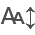

In [2]:
init_notebook_mode(all_interactive=True)

In [3]:
# !python src/example_package/healthkit_to_sqlite.py /Users/mjboothaus/icloud/Data/apple_health_export/export_2024_03_25.zip ./data/healthkit-2024-03-25-fix.db

In [4]:
def format_date(date_str):
    date_obj = datetime.strptime(date_str, "%Y-%m-%d %H:%M:%S %z")
    formatted_date = date_obj.strftime("%a %-d-%b-%Y %H:%M")
    return formatted_date

In [5]:
# This file was produced by the (commented) command above

HEALTH_DB = "../data/healthkit-2024-03-25-fix.db"

In [6]:
assert Path(HEALTH_DB).exists()

In [7]:
con = duckdb.connect(HEALTH_DB)
con.install_extension("sqlite")
con.load_extension("sqlite")
con.execute("SET enable_progress_bar = false;")

In [8]:
con.sql("PRAGMA show_tables");

In [9]:
walk_dates = [
    "2020-05-11",
    "2020-05-18",
    "2020-05-25",
    "2020-06-01",
    "2021-03-02",
    "2021-03-12",
    "2021-04-03",
    "2021-10-15",
    "2021-10-29",
    "2023-05-23",
    "2024-02-26",
    "2024-02-27",
]
all_dates = "', '".join(walk_dates)

In [10]:
walks_sql = f"""
SELECT 
    * FROM workouts 
    WHERE sourceName != 'AllTrails' 
    AND LEFT(startDate, 10) IN ('{all_dates}') 
    AND duration >= 40
"""

In [11]:
walks_df = con.sql(walks_sql).to_df()

In [12]:
walk_id = con.sql(walks_sql.replace("*", "id")).to_df()

In [13]:
walk_ids = walk_id["id"].values.tolist()

In [14]:
def update_map(m, df, walk_id, colour="blue", n=10):
    """
    Update the map with points from the DataFrame, labeling the start and end markers with the walk ID.

    Parameters:
    - m: The map object to update.
    - df: The DataFrame containing latitude and longitude columns.
    - walk_id: The ID of the walk, used for labeling markers.
    - n: Downsampling factor, indicating how many rows to skip. Default is 10, meaning every 10th row is taken.
    """
    # Downsample the DataFrame by taking every nth row
    df_downsampled = df.iloc[::n, :]

    points = df_downsampled[["latitude", "longitude"]].values.tolist()
    folium.PolyLine(points, color=colour, weight=3.5, opacity=1).add_to(m)

    # Add start marker with walk ID label
    folium.Marker(
        [df["latitude"].iloc[0], df["longitude"].iloc[0]],
        popup=f"Start of Walk ID: {walk_id}",
        icon=folium.Icon(color="green"),
    ).add_to(m)

    # Add end marker with walk ID label
    folium.Marker(
        [df["latitude"].iloc[-1], df["longitude"].iloc[-1]],
        popup=f"End of Walk ID: {walk_id}",
        icon=folium.Icon(color="red"),
    ).add_to(m)

    return m

In [15]:
@cache
def get_walk_data_for_id(con, id):
    walk_sql = """
    SELECT wp.*, w.startDate, w.duration
    FROM workout_points wp
    JOIN workouts w ON wp.workout_id = w.id
    WHERE wp.workout_id = ?
    """
    return con.execute(walk_sql, (id,)).fetchdf()

In [16]:
def create_map(walk_ids, con, SCALAR=1.00001):
    all_walks_df = {}
    m = folium.Map(location=None, zoom_start=12, tiles="openstreetmap")
    for id in tqdm(walk_ids, total=len(walk_ids)):
        logger.info(f"Getting data for walk ID: {id}")
        walk_df = get_walk_data_for_id(con, id)
        all_walks_df[id] = walk_df
        m = update_map(m, walk_df, id)
        bounds = m.get_bounds()
        scaled_bounds = [
            [bounds[0][0] / SCALAR, bounds[0][1] / SCALAR],
            [bounds[1][0] * SCALAR, bounds[1][1] * SCALAR],
        ]
        m.fit_bounds(scaled_bounds)
    return m, all_walks_df, bounds

In [17]:
m, all_walks_df, bounds = create_map(walk_ids, con)

  0%|          | 0/14 [00:00<?, ?it/s]

2024-03-26 19:56:21.532 | INFO     | __main__:create_map:5 - Getting data for walk ID: e0db8356ce08a6e309cd9501916310c70f6f9fca
2024-03-26 19:56:23.255 | INFO     | __main__:create_map:5 - Getting data for walk ID: c9050bc069d564b8f1fc778687fcdc7248e44a81
2024-03-26 19:56:24.667 | INFO     | __main__:create_map:5 - Getting data for walk ID: 8025add8b2b9526e979718533c118a4bbb6da89b
2024-03-26 19:56:25.964 | INFO     | __main__:create_map:5 - Getting data for walk ID: e5d9cb5f15e8465af32a635763e51e202a6c05aa
2024-03-26 19:56:27.336 | INFO     | __main__:create_map:5 - Getting data for walk ID: fc72a3b30353258834915980c2246d03aee398af
2024-03-26 19:56:28.651 | INFO     | __main__:create_map:5 - Getting data for walk ID: 848cf4e165e090258bf9668c2f6a04504fa73653
2024-03-26 19:56:29.960 | INFO     | __main__:create_map:5 - Getting data for walk ID: 6562e1378f9efa15e02b82366c5ef70e8ac9edf5
2024-03-26 19:56:31.278 | INFO     | __main__:create_map:5 - Getting data for walk ID: cd928dc50b2bc130d

In [18]:
m

In [19]:
@cache
def get_walk_start_end_locations(con):
    query = """
    SELECT DISTINCT
        wp.workout_id as id,
        CAST(w.duration AS FLOAT) as duration,
        w.startDate,
        FIRST_VALUE(wp.latitude) OVER (PARTITION BY wp.workout_id ORDER BY wp.date) AS start_latitude,
        FIRST_VALUE(wp.longitude) OVER (PARTITION BY wp.workout_id ORDER BY wp.date) AS start_longitude,
        LAST_VALUE(wp.latitude) OVER (PARTITION BY wp.workout_id ORDER BY wp.date ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING) AS end_latitude,
        LAST_VALUE(wp.longitude) OVER (PARTITION BY wp.workout_id ORDER BY wp.date ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING) AS end_longitude
    FROM workout_points wp
    JOIN workouts w ON wp.workout_id = w.id
    """
    return con.execute(query).fetchdf()

In [20]:
walk_start_end_df = get_walk_start_end_locations(con)

In [21]:
MIN_WALK_TIME_MINS = 45

In [22]:
def find_nearby_walks(walks_df, reference_walk_ids, ref_location="start", max_distance_km=1):
    """
    Find walks within a specified distance from the start or end locations of one or more reference walks.

    Parameters:
    - walks_df: DataFrame containing walks data with columns ['id', 'start_latitude', 'start_longitude', 'end_latitude', 'end_longitude', 'duration']
    - reference_walk_ids: A single ID or a list of IDs of the reference walks.
    - ref_location: 'start' or 'end', indicating whether to use the reference walks' start or end locations.
    - max_distance_km: The maximum distance in kilometers to consider a walk as nearby.

    Returns:
    - A list of tuples, each containing the reference walk ID, a nearby walk ID, and its distance from the reference location.
    """
    if isinstance(reference_walk_ids, str):
        reference_walk_ids = [reference_walk_ids]

    cumulative_nearby_walks = []

    for reference_walk_id in reference_walk_ids:
        # Extract the reference walk's location.
        reference_row = walks_df.loc[walks_df["id"] == reference_walk_id]
        if ref_location == "start":
            reference_point = (
                reference_row["start_latitude"].values[0],
                reference_row["start_longitude"].values[0],
            )
        else:  # 'end'
            reference_point = (
                reference_row["end_latitude"].values[0],
                reference_row["end_longitude"].values[0],
            )

        # Iterate through the DataFrame to find nearby walks.
        for row in walks_df.itertuples():
            target_point = (
                (row.end_latitude, row.end_longitude)
                if ref_location == "start"
                else (row.start_latitude, row.start_longitude)
            )

            distance = haversine(reference_point, target_point)
            if distance <= max_distance_km and row.id != reference_walk_id:
                cumulative_nearby_walks.append((reference_walk_id, row.id, distance))

    return cumulative_nearby_walks

In [38]:
nearby_walks = find_nearby_walks(
    walk_start_end_df[walk_start_end_df["duration"] >= 120],
    "74e4d25c7fe65703a27579a39cd19f31c01b2aae",
    ref_location="end",
    max_distance_km=5.0,
)

In [39]:
def plot_walks_and_nearby(walks_df, nearby_walks_info):
    """
    Plots the specified walk and nearby walks on a map, using the new structure of nearby_walks_info,
    and includes the Date of each walk in the markers.

    Parameters:
    - walks_df: DataFrame with columns ['id', 'start_latitude', 'start_longitude', 'end_latitude', 'end_longitude', 'startDate'] for each walk.
    - nearby_walks_info: A list of tuples (reference_walk_id, nearby_walk_id, distance_km) for nearby walks.
    """
    # Initialize an empty map. Adjust the location and zoom_start as needed.
    m = folium.Map(location=None, zoom_start=2)

    # Track plotted walks to avoid duplication
    plotted_walks = set()

    for ref_id, nearby_id, distance in nearby_walks_info:
        # Plot reference walk if not already plotted
        if ref_id not in plotted_walks:
            ref_walk = walks_df.loc[walks_df["id"] == ref_id].iloc[0]
            m = update_map(m, get_walk_data_for_id(con, ref_id), ref_id)
            formatted_date = format_date(ref_walk["startDate"])
            folium.Marker(
                [ref_walk["start_latitude"], ref_walk["start_longitude"]],
                popup=f"Ref Walk ID: {ref_id}<br>Date: {formatted_date}<br>",
                icon=folium.Icon(color="blue"),
            ).add_to(m)

        # Plot nearby walk(s)
        if nearby_id not in plotted_walks:
            nearby_walk = walks_df.loc[walks_df["id"] == nearby_id].iloc[0]
            m = update_map(m, get_walk_data_for_id(con, nearby_id), nearby_id, colour="red")
            formatted_date = format_date(nearby_walk["startDate"])
            folium.Marker(
                [nearby_walk["start_latitude"], nearby_walk["start_longitude"]],
                popup=f"Nearby Walk ID: {nearby_id}<br>Date: {formatted_date}<br>Dist: {distance:.2f} km",
                icon=folium.Icon(color="red"),
            ).add_to(m)
            plotted_walks.add(nearby_id)

    # Automatically adjust bounds to include all markers
    m.fit_bounds(m.get_bounds())

    return m

In [45]:
start_walk = "74e4d25c7fe65703a27579a39cd19f31c01b2aae"

In [83]:
walk_list = [start_walk]
nearby_walks_dict = {}

for i in range(0, 10):
    nearby_walks = find_nearby_walks(walk_start_end_df[walk_start_end_df["duration"] >= 170], walk_list[i],
        ref_location="end", max_distance_km=2.0,
    )
    nearby_walks_dict[walk_list[i]] = nearby_walks
    try:
        walk_list.append(nearby_walks[0][1])
    except IndexError:
        break

In [84]:
from pprint import pprint

pprint(nearby_walks_dict)

{'030f0004c472d9d5e95e217b1e18bb6929d5c407': [('030f0004c472d9d5e95e217b1e18bb6929d5c407',
                                               'cd928dc50b2bc130ded66cc7e87944732bfcc02c',
                                               0.136638497484)],
 '74e4d25c7fe65703a27579a39cd19f31c01b2aae': [('74e4d25c7fe65703a27579a39cd19f31c01b2aae',
                                               '030f0004c472d9d5e95e217b1e18bb6929d5c407',
                                               0.016736260912566334)],
 'cd928dc50b2bc130ded66cc7e87944732bfcc02c': []}


In [85]:
walk_list

['74e4d25c7fe65703a27579a39cd19f31c01b2aae',
 '030f0004c472d9d5e95e217b1e18bb6929d5c407',
 'cd928dc50b2bc130ded66cc7e87944732bfcc02c']

In [76]:
m2, all_walks2_df, bounds2 = create_map(list(set(walk_list)), con)

  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-29 17:26:23.513 | INFO     | __main__:create_map:5 - Getting data for walk ID: 74e4d25c7fe65703a27579a39cd19f31c01b2aae
2024-03-29 17:26:23.529 | INFO     | __main__:create_map:5 - Getting data for walk ID: e401a6f2d3e2b780e78df951c8c2ca494359ec4c


2024-03-29 17:26:23.537 | INFO     | __main__:create_map:5 - Getting data for walk ID: 030f0004c472d9d5e95e217b1e18bb6929d5c407
2024-03-29 17:26:23.550 | INFO     | __main__:create_map:5 - Getting data for walk ID: 5f195783adfc8e0eacd5706af393334380041ad7
2024-03-29 17:26:23.564 | INFO     | __main__:create_map:5 - Getting data for walk ID: cd928dc50b2bc130ded66cc7e87944732bfcc02c


In [77]:
m2

In [34]:
m = plot_walks_and_nearby(walk_start_end_df, nearby_walks)

In [35]:
m

In [28]:
walk_start_end_df.iloc[0]["startDate"]

'2019-04-20 17:30:31 +1100'